In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("../names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
alphabet = ["."] + list("abcdefghijklmnopqrstuvwxyz")
stoi = {c: i for i, c in enumerate(alphabet)}
itos = {i: c for i, c in enumerate(alphabet)}

In [5]:
# build the dataset

block_size = 3 # how many chars do we take to predict the next one
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "----->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [6]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [7]:
C = torch.randn((27, 2)) # embedding lookup

In [8]:
C[5]

tensor([-2.6403,  1.2789])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-2.6403,  1.2789])

In [10]:
C[X].shape

torch.Size([32, 3, 2])

In [11]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
emb.view(32, -1).shape

torch.Size([32, 6])

In [14]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [15]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [16]:
emb.view(-1, 6) @ W1 + b1

tensor([[ 1.6487,  2.0761, -2.1154,  ..., -1.0748,  0.6696, -1.3345],
        [ 3.1558,  4.7716, -1.8785,  ..., -3.5373,  3.0511, -1.4601],
        [-1.9476,  3.4110, -4.6199,  ..., -0.6041, -3.5416, -4.8619],
        ...,
        [ 1.6764,  2.6437,  2.7410,  ...,  0.6911,  3.7463,  2.3815],
        [-0.7012,  3.4301, -0.2902,  ..., -1.1528,  3.8777,  3.3636],
        [-7.5819,  0.1773,  2.0939,  ...,  3.4355,  2.9556,  1.1977]])

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2

logits.shape

torch.Size([32, 27])

In [20]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [21]:
-prob[torch.arange(32), Y].log().mean()

tensor(16.7534)

In [22]:
# --- rewrite and clean up ---

In [23]:
# build the dataset

block_size = 3 # how many chars do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "----->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [24]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [25]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:
sum(p.nelement() for p in parameters)

3481

In [28]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [29]:
# lri = []
# lossi = []
for i in range(10000):
    batch_ixs = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[batch_ixs]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
    reg = 0.05 * sum((p ** 2).mean() for p in parameters)
    loss = F.cross_entropy(logits, Y[batch_ixs]) + reg
    
    if (i + 1) % 1000 == 0:
        emb = C[X]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        overall_loss = F.cross_entropy(logits, Y)
        print(f"loss at step {i+1} = {overall_loss.item()}")

    for p in parameters:
        p.grad = None

    # lossi.append(loss.item())
    loss.backward()
    # lr = lrs[i]
    lr = 0.002
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    # lri.append(lr)
        
# base model had loss of 2.35

loss at step 1000 = 8.339794158935547
loss at step 2000 = 5.773024559020996
loss at step 3000 = 4.567688941955566
loss at step 4000 = 3.9008214473724365
loss at step 5000 = 3.55029559135437
loss at step 6000 = 3.3327414989471436
loss at step 7000 = 3.188147783279419
loss at step 8000 = 3.0832204818725586
loss at step 9000 = 3.0049476623535156
loss at step 10000 = 2.941922664642334


In [30]:
# plt.plot(lri, lossi)

In [31]:
# training split, dev/validation split, test split
# train params, train hyperparams, evaluate (should be done infrequently)
# 80, 10, 10

In [32]:
import random

In [33]:
def build_dataset(words):
    random.seed(42)
    random.shuffle(words)
    
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    Xtr, Ytr = X[:n1], Y[:n1]
    Xdev, Ydev = X[n1:n2], Y[n1:n2]
    Xte, Yte = X[n2:], Y[n2:]

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words)

In [34]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
for p in parameters:
    p.requires_grad = True

In [36]:
sum(p.nelement() for p in parameters)

10281

In [37]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [38]:
# lri = []
# lossi = []
# stepi = []

for i in range(30000):
    batch_ixs = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[batch_ixs]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # reg = 0.05 * sum((p ** 2).mean() for p in parameters)
    loss = F.cross_entropy(logits, Ytr[batch_ixs])


    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    # alpha = 0.175
    # gamma = 1
    # beta = -np.log(gamma) - 1
    # lr = np.exp(-((i + 1) ** alpha + beta))
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # stepi.append(i)
    # lri.append(lr)
    # lossi.append(loss.item())

    # if (i + 1) % 1000 == 0:
    #     emb = C[Xtr]
    #     h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    #     logits = h @ W2 + b2
    #     overall_loss = F.cross_entropy(logits, Ytr)
    #     print(f"tr loss at step {i+1} = {overall_loss.item()}")

In [39]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
overall_loss = F.cross_entropy(logits, Ytr)
print(f"tr loss at step {i+1} = {overall_loss.item()}")

tr loss at step 30000 = 2.464905261993408


In [40]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
overall_loss = F.cross_entropy(logits, Ydev)
print(f"dev loss at step {i+1} = {overall_loss.item()}")

dev loss at step 30000 = 2.4854488372802734


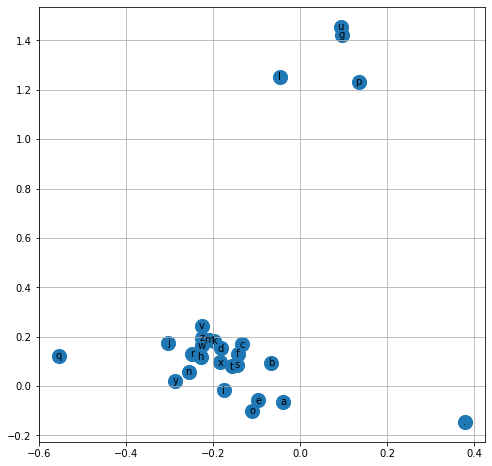

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center")
plt.grid("minor")

In [43]:
# scale up to 10d embeddings
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
for p in parameters:
    p.requires_grad = True

In [45]:
sum(p.nelement() for p in parameters)

11897

In [46]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [47]:
lri = []
lossi = []
stepi = []

In [48]:
import numpy as np

In [49]:
for i in range(200000):
    batch_ixs = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[batch_ixs]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    reg = 0.05 * sum((p ** 2).mean() for p in parameters)
    loss = F.cross_entropy(logits, Ytr[batch_ixs]) + reg


    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    alpha = 0.135
    gamma = 1
    beta = -np.log(gamma) - 1
    lr = np.exp(-((i + 1) ** alpha + beta))
    for p in parameters:
        p.data -= lr * p.grad

    stepi.append(i)
    # lri.append(lr)
    lossi.append(loss.log10().item())

    if (i + 1) % 1000 == 0:
        print("--------------------")
        emb = C[Xtr]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        overall_loss = F.cross_entropy(logits, Ytr)
        print(f"tr loss at step {i+1} = {overall_loss.item()}")
        emb = C[Xdev]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        overall_loss = F.cross_entropy(logits, Ydev)
        print(f"dev loss = {overall_loss.item()}")
        print(f"lr = {lr}")

--------------------
tr loss at step 1000 = 3.426938533782959
dev loss = 3.707991123199463
lr = 0.21417267312607005
--------------------
tr loss at step 2000 = 2.87309193611145
dev loss = 3.2002267837524414
lr = 0.16692279681244065
--------------------
tr loss at step 3000 = 2.633845806121826
dev loss = 2.9392006397247314
lr = 0.14267129234635761
--------------------
tr loss at step 4000 = 2.4983513355255127
dev loss = 2.803725004196167
lr = 0.1269547216796825
--------------------
tr loss at step 5000 = 2.494961738586426
dev loss = 2.792266607284546
lr = 0.11559900858694484
--------------------
tr loss at step 6000 = 2.4609804153442383
dev loss = 2.757525682449341
lr = 0.10685182016761786
--------------------
tr loss at step 7000 = 2.4817519187927246
dev loss = 2.7771127223968506
lr = 0.09982199903217022
--------------------
tr loss at step 8000 = 2.3680572509765625
dev loss = 2.642892360687256
lr = 0.09399875128192368
--------------------
tr loss at step 9000 = 2.3484280109405518
dev 

KeyboardInterrupt: 

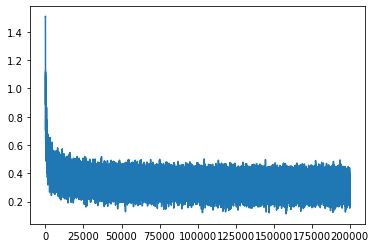

In [416]:
plt.plot(stepi, lossi)

In [417]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
overall_loss = F.cross_entropy(logits, Ytr)
overall_loss

tensor(1.9813, grad_fn=<NllLossBackward0>)

In [418]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
overall_loss = F.cross_entropy(logits, Ydev)
overall_loss

tensor(2.4146, grad_fn=<NllLossBackward0>)

In [51]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carmahzaan.
hari.
kimberretty.
salayan.
jazonte.
amerync.
kaqhilor.
mari.
chaiir.
kaleigh.
ham.
jois.
quston.
rove.
alianni.
wazeron.
jaryn.
kakhengiylan.
emderica.
gianahya.
kaylaad.
bulah.
sya.
smalon.
zeryxonni.
alairo.
nee.
kaadin.
oceanner.
oza.
krynce.
mollianna.
seden.
loqhaib.
bren.
adyn.
tituso.
collietpranis.
qukorce.
zazingtyn.
khengel.
antezamilenn.
kyperylon.
rour.
konston.
kirockoleiler.
shan.
elanini.
eronel.
kyroseyah.
keliah.
mawryston.
hani.
kayleyah.
cah.
kolani.
ari.
kaal.
mav.
kento.
itza.
ryn.
kel.
catiylandelah.
jouleen.
dhandara.
dakhakeer.
tan.
aviana.
jmanah.
theley.
wayar.
ledyn.
vheopmy.
mari.
maria.
mavyonoraiyel.
abyana.
kimberliseynasvia.
moline.
talenostefa.
kemon.
jaei.
emya.
kenne.
natytura.
caxleon.
cendesabelw.
evrixah.
zeniusayealudrakian.
abrithiannaedeassi.
emmadious.
biwhanned.
teanne.
kzon.
keidhahayia.
kayj.
shaythais.
lote.
atdlynnamiana.
